## Import library & dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import joblib

Daftar fitur:
1. distance_from_home: The distance from home to the transaction location.
2. distance_from_last_transaction: The distance from the last transaction location.
3. ratio_to_median_purchase_price: The ratio of the transaction amount to the median purchase price.
4. repeat_retailer: Whether the transaction was made at the same retailer.
5. used_chip: Whether the transaction was made using a chip (credit card).
6. used_pin_number: Whether the transaction was made using a PIN.
7. online_order: Whether the transaction was an online order.
8. fraud: Whether the transaction was fraudulent.

In [2]:
df = pd.read_csv("card_transdata.csv")[:1500]

In [3]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


## EDA

In [4]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,26.095038,5.151163,1.745826,0.891333,0.320000,0.110667,0.658667,0.086667
std,59.221496,29.917602,2.569414,0.311324,0.466632,0.313824,0.474315,0.281440
min,0.104184,0.001448,0.016933,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.925749,0.320943,0.490621,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.615044,1.073501,1.001526,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.077419,3.298540,1.967269,1.000000,1.000000,0.000000,1.000000,0.000000
max,965.910612,990.070315,41.023449,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              1500 non-null   float64
 1   distance_from_last_transaction  1500 non-null   float64
 2   ratio_to_median_purchase_price  1500 non-null   float64
 3   repeat_retailer                 1500 non-null   float64
 4   used_chip                       1500 non-null   float64
 5   used_pin_number                 1500 non-null   float64
 6   online_order                    1500 non-null   float64
 7   fraud                           1500 non-null   float64
dtypes: float64(8)
memory usage: 93.9 KB


In [6]:
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [7]:
df["fraud"].value_counts() / 1000000 * 100

fraud
0.0    0.137
1.0    0.013
Name: count, dtype: float64

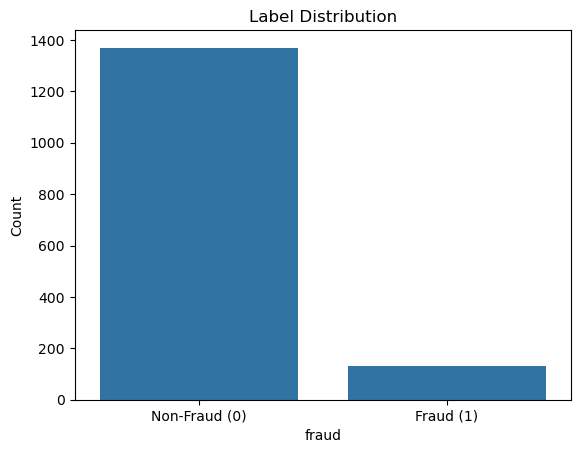

In [8]:
sns.countplot(x='fraud', data=df)
plt.title('Label Distribution')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.ylabel('Count')
plt.show()

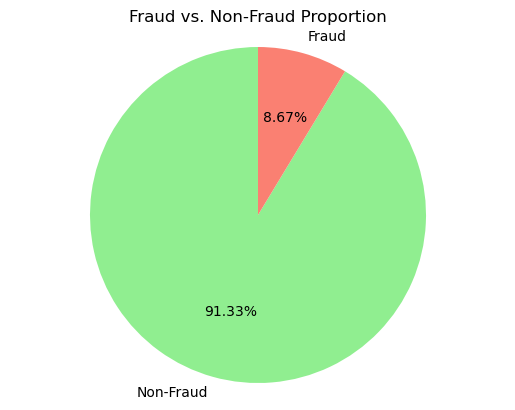

In [9]:
fraud_counts = df['fraud'].value_counts()
labels = ['Non-Fraud', 'Fraud']

plt.pie(fraud_counts, labels=labels, autopct='%1.2f%%', startangle=90, colors=['lightgreen', 'salmon'])
plt.title('Fraud vs. Non-Fraud Proportion')
plt.axis('equal')
plt.show()

In [10]:
print(df['fraud'].unique())
print(df['online_order'].unique())
print(df['used_chip'].unique())
print(df['used_pin_number'].unique()) 
print(df['repeat_retailer'].unique())

[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]


In [11]:
print(df['distance_from_home'].unique())
print(df['distance_from_last_transaction'].unique())
print(df['ratio_to_median_purchase_price'].unique())

[57.87785658 10.8299427   5.09107949 ...  8.90714723 28.60221153
 18.58345087]
[0.31114001 0.1755915  0.80515259 ... 1.84249371 7.75944621 6.78375986]
[1.94593998 1.29421881 0.42771456 ... 0.15898863 1.44118451 3.51459575]


In [12]:
df['fraud'] = df['fraud'].astype(int)
df['online_order'] = df['fraud'].astype(int)
df['used_chip'] = df['used_chip'].astype(int)
df['used_pin_number'] = df['used_pin_number'].astype(int)
df['repeat_retailer'] = df['repeat_retailer'].astype(int)

# Model dan Evaluasi

In [13]:
# Normalisasi fitur
scaler = StandardScaler()
X = df.drop('fraud', axis=1)
y = df['fraud']
X_scaled = scaler.fit_transform(X)

In [14]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

In [15]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [16]:
# Definisikan model
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
}

In [17]:
# Train dan evaluasi model
fold_results = []  # Save metrics for each fold
summary_results = []  # Save average metrics per model

for name, model in models.items():
    acc_scores, f1_scores, prec_scores, rec_scores = [], [], [], []

    print(f"\n🔍 Training: {name}")

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)

        acc = accuracy_score(y_test_cv, y_pred)
        f1 = f1_score(y_test_cv, y_pred)
        prec = precision_score(y_test_cv, y_pred)
        rec = recall_score(y_test_cv, y_pred)
    
        # Save scores for this fold
        fold_results.append({
            'Model': name,
            'Fold': fold,
            'Accuracy': acc,
            'F1 Score': f1,
            'Precision': prec,
            'Recall': rec
        })

        # Accumulate for average
        acc_scores.append(acc)
        f1_scores.append(f1)
        prec_scores.append(prec)
        rec_scores.append(rec)

    # Save average results
    summary_results.append({
        'Model': name,
        'Accuracy': np.mean(acc_scores),
        'F1 Score': np.mean(f1_scores),
        'Precision': np.mean(prec_scores),
        'Recall': np.mean(rec_scores)
    })



🔍 Training: Random Forest

🔍 Training: Decision Tree

🔍 Training: Logistic Regression

🔍 Training: KNN


In [18]:
fold_results_df = pd.DataFrame(fold_results)
summary_results_df = pd.DataFrame(summary_results)

In [19]:
fold_results_df[fold_results_df["Model"] == "Random Forest"]

,Model,Fold,Accuracy,F1 Score,Precision,Recall
0,Random Forest,1,1.0,1.0,1.0,1.0
1,Random Forest,2,1.0,1.0,1.0,1.0
2,Random Forest,3,1.0,1.0,1.0,1.0
3,Random Forest,4,1.0,1.0,1.0,1.0
4,Random Forest,5,1.0,1.0,1.0,1.0
5,Random Forest,6,1.0,1.0,1.0,1.0
6,Random Forest,7,1.0,1.0,1.0,1.0
7,Random Forest,8,1.0,1.0,1.0,1.0
8,Random Forest,9,1.0,1.0,1.0,1.0
9,Random Forest,10,1.0,1.0,1.0,1.0


In [20]:
fold_results_df[fold_results_df["Model"] == "Decision Tree"]

,Model,Fold,Accuracy,F1 Score,Precision,Recall
10,Decision Tree,1,1.0,1.0,1.0,1.0
11,Decision Tree,2,1.0,1.0,1.0,1.0
12,Decision Tree,3,1.0,1.0,1.0,1.0
13,Decision Tree,4,1.0,1.0,1.0,1.0
14,Decision Tree,5,1.0,1.0,1.0,1.0
15,Decision Tree,6,1.0,1.0,1.0,1.0
16,Decision Tree,7,1.0,1.0,1.0,1.0
17,Decision Tree,8,1.0,1.0,1.0,1.0
18,Decision Tree,9,1.0,1.0,1.0,1.0
19,Decision Tree,10,1.0,1.0,1.0,1.0


In [21]:
fold_results_df[fold_results_df["Model"] == "Logistic Regression"]

,Model,Fold,Accuracy,F1 Score,Precision,Recall
20,Logistic Regression,1,1.000000,1.000000,1.000000,1.0
21,Logistic Regression,2,1.000000,1.000000,1.000000,1.0
22,Logistic Regression,3,1.000000,1.000000,1.000000,1.0
23,Logistic Regression,4,0.993333,0.962963,0.928571,1.0
24,Logistic Regression,5,0.993333,0.962963,0.928571,1.0
25,Logistic Regression,6,1.000000,1.000000,1.000000,1.0
26,Logistic Regression,7,0.993333,0.962963,0.928571,1.0
27,Logistic Regression,8,1.000000,1.000000,1.000000,1.0
28,Logistic Regression,9,1.000000,1.000000,1.000000,1.0
29,Logistic Regression,10,1.000000,1.000000,1.000000,1.0


In [22]:
fold_results_df[fold_results_df["Model"] == "KNN"]

,Model,Fold,Accuracy,F1 Score,Precision,Recall
30,KNN,1,0.960000,0.750000,0.818182,0.692308
31,KNN,2,0.926667,0.476190,0.625000,0.384615
32,KNN,3,0.953333,0.695652,0.800000,0.615385
33,KNN,4,0.906667,0.416667,0.454545,0.384615
34,KNN,5,0.940000,0.666667,0.642857,0.692308
35,KNN,6,0.920000,0.454545,0.555556,0.384615
36,KNN,7,0.920000,0.333333,0.600000,0.230769
37,KNN,8,0.960000,0.785714,0.733333,0.846154
38,KNN,9,0.940000,0.608696,0.700000,0.538462
39,KNN,10,0.920000,0.500000,0.545455,0.461538


In [23]:
print("\n📈 Average Evaluation:")
summary_results_df


📈 Average Evaluation:


,Model,Accuracy,F1 Score,Precision,Recall
0,Random Forest,1.000000,1.000000,1.000000,1.000000
1,Decision Tree,1.000000,1.000000,1.000000,1.000000
2,Logistic Regression,0.998000,0.988889,0.978571,1.000000
3,KNN,0.934667,0.568746,0.647493,0.523077


Terlihat bahwa model KNN memiliki F1 score paling buruk. Hal ini dikarenakan data yang sangat imbalance menyebabkan model bias memprediksi non-fraud.

"KNN relies on neighbor counts, so the nearest neighbors are almost always non-fraud (majority class)."

## SMOTE

In [24]:
# pip install imbalanced-learn

In [25]:
from imblearn.over_sampling import SMOTE

In [26]:
smote = SMOTE(random_state=42)

In [27]:
# Train dan evaluasi model
fold_results = []  
summary_results = []  

for name, model in models.items():
    acc_scores, f1_scores, prec_scores, rec_scores = [], [], [], []
    model_name = name + " + SMOTE"
    
    print(f"\n🔍 Training: {model_name}")

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        X_train_res, y_train_res = smote.fit_resample(X_train_cv, y_train_cv)

        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_cv)

        acc = accuracy_score(y_test_cv, y_pred)
        f1 = f1_score(y_test_cv, y_pred)
        prec = precision_score(y_test_cv, y_pred)
        rec = recall_score(y_test_cv, y_pred)
    
        # Save scores for this fold
        fold_results.append({
            'Model': model_name,
            'Fold': fold,
            'Accuracy': acc,
            'F1 Score': f1,
            'Precision': prec,
            'Recall': rec
        })

        # Accumulate for average
        acc_scores.append(acc)
        f1_scores.append(f1)
        prec_scores.append(prec)
        rec_scores.append(rec)

    # Save average results
    summary_results.append({
        'Model': model_name,
        'Accuracy': np.mean(acc_scores),
        'F1 Score': np.mean(f1_scores),
        'Precision': np.mean(prec_scores),
        'Recall': np.mean(rec_scores)
    })


🔍 Training: Random Forest + SMOTE

🔍 Training: Decision Tree + SMOTE

🔍 Training: Logistic Regression + SMOTE

🔍 Training: KNN + SMOTE


In [28]:
fold_results_df_smote = pd.DataFrame(fold_results)
summary_results_df_smote = pd.DataFrame(summary_results)

In [29]:
fold_results_df_smote[fold_results_df_smote["Model"] == "KNN + SMOTE"]

,Model,Fold,Accuracy,F1 Score,Precision,Recall
30,KNN + SMOTE,1,0.953333,0.774194,0.666667,0.923077
31,KNN + SMOTE,2,0.906667,0.588235,0.476190,0.769231
32,KNN + SMOTE,3,0.913333,0.628571,0.500000,0.846154
33,KNN + SMOTE,4,0.913333,0.648649,0.500000,0.923077
34,KNN + SMOTE,5,0.920000,0.684211,0.520000,1.000000
35,KNN + SMOTE,6,0.926667,0.645161,0.555556,0.769231
36,KNN + SMOTE,7,0.926667,0.645161,0.555556,0.769231
37,KNN + SMOTE,8,0.920000,0.666667,0.521739,0.923077
38,KNN + SMOTE,9,0.940000,0.727273,0.600000,0.923077
39,KNN + SMOTE,10,0.926667,0.666667,0.550000,0.846154


In [30]:
print("\n📈 Average Evaluation:")
summary_results_df_smote


📈 Average Evaluation:


,Model,Accuracy,F1 Score,Precision,Recall
0,Random Forest + SMOTE,1.000000,1.000000,1.000000,1.000000
1,Decision Tree + SMOTE,1.000000,1.000000,1.000000,1.000000
2,Logistic Regression + SMOTE,0.998000,0.988889,0.978571,1.000000
3,KNN + SMOTE,0.924667,0.667479,0.544571,0.869231


Oversampling menggunakan SMOTE meningkatkan F1 score dari model KNN. Namun, tetap saja hasilnya masih jauh dari kata memuaskan. Oleh karena itu, untuk kasus Fraud detection dengan ciri dataset yang over-imbalanced menggunakan classifier yang lebih robust seperti Random Forest atau Decision Tree.

## Simpan model

In [31]:
joblib.dump(scaler, './models/scaler.pkl')

['./models/scaler.pkl']

In [32]:
for name, model in models.items():   
    joblib.dump(model, f"./models/{name.lower().replace(' ', '_')}_model.pkl")